In [27]:
import pandas as pd
from datetime import datetime, timedelta
from time import time

from voter.rshares import simulate_vote

import matplotlib.pyplot as plt

%matplotlib notebook


def is_bid(memo):
    if isinstance(memo, str):
#         return memo.startswith('https://steemit.com')
        return memo.startswith('https://')
    return False

def get_currency(amount):
    return amount.split(' ')[1]

def get_value(amount):
    return float(amount.split(' ')[0])

def parse_amount(amount):
    amount = amount.split(' ')
    return float(amount[0]), amount[1]

def get_permlink(url):
    return url.split('/')[-1]

def get_author(url):
    return url.split('/')[-2][1:]

def get_ap(url):
    url = url.split('/')
    return url[-2][1:], url[-1]

def parse_timestamp(timestamp):
    return datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')

def get_rshares_to_sbd():
    from steevebase.io import steem_factory
    steemd = steem_factory().steemd
    reward_fund = steemd.get_reward_fund('post')
    sbd_price = steemd.get_current_median_history_price()['base']
    RSHARES_TO_SBD = 1 / get_value(reward_fund['recent_claims']) * get_value(reward_fund['reward_balance']) * get_value(sbd_price)
    return RSHARES_TO_SBD

In [2]:
from steevebase.io import mongo_factory
from voter.config import CONFIG

mongo_address = CONFIG['DATABASE']['ADDRESS']
TIME_FORMAT = CONFIG['TIME_FORMAT']

db = mongo_factory(mongo_address)
known_bidbots_col = db.get_collection('known_bidbots')
KNOWN_BIDBOTS = {x['_id'] for x in known_bidbots_col.find()}

### Checks for simulating the voter

In [3]:
from steem.post import Post
import numpy as np

MIN_ALLOWED_PAYOUT = 1000

COMPARISON_THRESHOLD = 0.8

time_limits_sec = {
    'buildawhale': 3 * 24 * 3600,
    'emperorofnaps': 5 * 24 * 3600,
    'minnowbooster': 2 * 24 * 3600,
    'ocdb': 3 * 24 * 3600,
    'smartsteem': 3.5 * 24 * 3600,
    '': 5 * 24 * 3600, # default
}

amount_limits = {
    'upme': [3, 100],
    'postpromoter': [0, 49.999],
    'minnowbooster': [0.01, 1000], # Min: 0.01, Max: 13.35, Max-Whitelist: 22.62
    'brupvoter' : [0, 2.5],
}

def get_id(memo):
    return memo.split('@')[-1]

def get_post(transfer, post_cache={}):
    post_id = get_id(transfer['memo'])
    if post_id in post_cache:
        return post_cache[post_id]
    
    try:
        post = Post(post_id)
        post_cache[post_id] = post
        return post
    except:
        return None

def _parse_vote_time(vote_time):
    return datetime.strptime(vote_time, '%Y-%m-%dT%H:%M:%S')

def _get_post_payout(post):
    return post.total_payout_value / 0.75 + post.pending_payout_value    

def is_failed_vote(post, transfer):
    return transfer['amount'] * COMPARISON_THRESHOLD > _get_post_payout(post)

############ CHECKS_BID ################################################

def not_a_bid(transfer):
    return not is_bid(transfer['memo'])

def bidbot_not_known(transfer):
    bidbot = transfer['to']
    return not bidbot in KNOWN_BIDBOTS

def is_out_of_bounds(transfer):
    bidbot = transfer['to']
    amount = get_value(transfer['amount'])
    if bidbot in amount_limits:
        return (amount < amount_limits[bidbot][0]) or (amount > amount_limits[bidbot][1])
    return False

def sneaky_ninja_steem(transfer):
    return transfer['to'] == 'sneaky-ninja' and get_currency(transfer['amount']) == 'STEEM'

def target_is_bidbot(transfer):
    return get_author(transfer['memo']) in KNOWN_BIDBOTS

############ CHECKS_POST_BID ###########################################

def post_doesnt_exist(post, transfer):
    return post is None

def post_too_old(post, transfer):
    bidbot = transfer['to']
    if bidbot not in time_limits_sec:
        bidbot = ''
    delay = (transfer['timestamp'] - post['created']).total_seconds()
    return delay > time_limits_sec[bidbot]

def bot_already_voted(post, transfer):
    bidbot = transfer['to']
    vote_times = {x['voter']: x['time'] for x in post['active_votes']}
    return bidbot in vote_times and _parse_vote_time(vote_times[bidbot]) < transfer['timestamp']

def curation_not_allowed(post, transfer):
    return not post['allow_curation_rewards']

def max_payout_too_low(post, transfer):
    return post['max_accepted_payout']['amount'] < MIN_ALLOWED_PAYOUT

##########################################################################

def vote_strength_ok(rshares, rshares_hr1):
    # vote strength from (0.01% and 100%>
    if rshares > 0.0001 * rshares_hr1 and rshares <= rshares_hr1:
        return True
    return False
    

##########################################################################

CHECKS_BID = [
    not_a_bid,
    bidbot_not_known,
    target_is_bidbot,
    is_out_of_bounds,
    sneaky_ninja_steem,
]
CHECKS_POST_BID = [
    post_doesnt_exist,
    post_too_old,
    bot_already_voted,
    curation_not_allowed,
    max_payout_too_low
]

def bid_invalid(bid):
    for check in CHECKS_BID:
        if check(bid):
            return True

    return False

def post_bid_invalid(post, bid):
    for check in CHECKS_POST_BID:
        if check(post, bid):
            return True

    return False

In [4]:
post_cache = {}

In [4]:
import pickle
with open('post_cache.pkl', 'rb') as f:
    post_cache_export = pickle.load(f)

In [6]:
# import pickle

# for k,v in post_cache.items():
#     post_cache[k] = v.export()

# with open('post_cache.pkl', 'wb') as f:
#     pickle.dump(post_cache, f)

In [5]:
transfers = pd.read_csv('/root/transfers_2018-10-07-10-00-06.csv')
transfers['timestamp'] = transfers['timestamp'].apply(parse_timestamp)

In [6]:
sp_voter = 170526.348 + 1969.475
sp_void = 43262.958
rshares_hr1 = 8699297694833 * sp_voter / (sp_voter + sp_void + 50162.13)

RSHARES_TO_SBD = get_rshares_to_sbd()

In [18]:
global_params = {
#     'MULTIPLIER' :  220,
#     'MULTIPLIER' :  20,
#     'MULTIPLIER' :  35,
#     'MULTIPLIER' :  30.3,
    'MULTIPLIER' :  17.7,
    'STEEM_PRICE_USD': .793726,
    'SBD_PRICE_USD': .972664,
    'RSHARES_TO_SBD': RSHARES_TO_SBD,
#     'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 4,
    'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 8,
#     'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 12,
#     'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 32,
#     'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 128,
#     'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 1024,
#     'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 1500,
    'N_VOTES': 10,
    'rshares_hr1': rshares_hr1
}

def get_expected_payout(amount):
    value = get_value(amount)
    currency = get_currency(amount)
    return value if currency == 'SBD' else value * global_params['STEEM_PRICE_USD'] / global_params['SBD_PRICE_USD']   

In [19]:
simulation_df = pd.DataFrame(index=post_cache_export.keys(), columns=['expected_reward', 'used_rshares', 'bid_amount', 'updated'])
simulation_df['updated'] = False

In [20]:
from voter.rshares import simulate_vote
# from importlib import reload
# reload(voter)
# simulate_vote = voter.rshares.simulate_vote

print('MULTIPLIER', global_params['MULTIPLIER'])
print('BASELINE_THRESHOLD', global_params['BASELINE_THRESHOLD'], '\n')

total_payouts_sum = 78543.460

time_diff = time()

counter = 0

for i, (idx, bid) in enumerate(transfers.iterrows()):
    if i % int(len(transfers) / 10) == 0:
        print('%d%%' % (100 * i / len(transfers)), time() - time_diff)
        time_diff = time()

    if bid_invalid(bid):
        continue
        
#     post = get_post(bid, post_cache)
    post = get_post(bid, post_cache_export)

    if post_bid_invalid(post, bid):
        continue
    
    bid_amount_sbd = get_expected_payout(bid['amount'])
    
    simulation_df.loc[post["identifier"]] = simulate_vote(bid_amount_sbd, total_payouts_sum, post, bid, global_params, simulation_df)
    counter += 1
#     break
    
#     expected_rewards.append(expected_reward)
#     rshares_used.append(hrshares)

print('\n%d%% used bids' % (simulation_df[simulation_df['updated']].shape[0] / simulation_df.shape[0] * 100))
simulation_df['percent_used'] = simulation_df['used_rshares'] / rshares_hr1 * 100

MULTIPLIER 17.7
BASELINE_THRESHOLD 2.754448267161347e-12 

0% 0.8222396373748779
10% 6.202650308609009
20% 3.681622266769409
30% 4.376024484634399
40% 3.170290470123291
50% 1.272385835647583
60% 2.2661895751953125
70% 1.996030330657959
80% 2.256998300552368
90% 3.473665952682495

26% used bids


In [36]:
simulation_df[simulation_df['updated']].shape[0]

559

## Evaluation

#### 'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 4, Multiplier = 14

In [27]:
expected_rewards = np.array([x if isinstance(x, (int, float)) else x.amount for x in expected_rewards])
rshares_used = np.array(rshares_used)
rshares_used_sum = rshares_used.sum()
print('%.2f%% voting power used' % (100 * rshares_used_sum / rshares_hr1 / global_params['N_VOTES']))
expected_rewards.sum()

102.71% voting power used


293.0279101955309

#### 'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 8, Multiplier = 20

In [9]:
expected_rewards = np.array([x if isinstance(x, (int, float)) else x.amount for x in expected_rewards])
rshares_used = np.array(rshares_used)
rshares_used_sum = rshares_used.sum()
print('%.2f%% voting power used' % (100 * rshares_used_sum / rshares_hr1 / global_params['N_VOTES']))
expected_rewards.sum()

101.99% voting power used


343.2455540132975

#### 'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 16, Multiplier = 40

In [15]:
expected_rewards = np.array([x if isinstance(x, (int, float)) else x.amount for x in expected_rewards])
rshares_used = np.array(rshares_used)
rshares_used_sum = rshares_used.sum()
print('%.2f%% voting power used' % (100 * rshares_used_sum / rshares_hr1 / global_params['N_VOTES']))
expected_rewards.sum()

21.16% voting power used


84.85588959797761

#### 'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 12, Multiplier = 35

In [36]:
expected_rewards = np.array([x if isinstance(x, (int, float)) else x.amount for x in expected_rewards])
rshares_used = np.array(rshares_used)
rshares_used_sum = rshares_used.sum()
print('%.2f%% voting power used' % (100 * rshares_used_sum / rshares_hr1 / global_params['N_VOTES']))
expected_rewards.sum()

95.18% voting power used


327.6106405192495

## Increasing vote strength on pending

#### 'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 12, Multiplier = 35

In [19]:
rshares_used_sum = simulation_df['used_rshares'].sum()
print('%.2f%% voting power used' % (rshares_used_sum / rshares_hr1 / global_params['N_VOTES'] * 100))
simulation_df['expected_reward'].sum()

60.64% voting power used


222.43288302997306

#### 'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 4, Multiplier = 20

In [38]:
rshares_used_sum = simulation_df['used_rshares'].sum()
print('%.2f%% voting power used' % (rshares_used_sum / rshares_hr1 / global_params['N_VOTES'] * 100))
simulation_df['expected_reward'].sum()

100.27% voting power used


278.4173250083983

#### 'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 8, Multiplier = 35

In [43]:
rshares_used_sum = simulation_df['used_rshares'].sum()
print('%.2f%% voting power used' % (rshares_used_sum / rshares_hr1 / global_params['N_VOTES'] * 100))
simulation_df['expected_reward'].sum()

115.23% voting power used


356.1604009615832

#### 'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 8, Multiplier = 30.3

In [48]:
rshares_used_sum = simulation_df['used_rshares'].sum()
print('%.2f%% voting power used' % (rshares_used_sum / rshares_hr1 / global_params['N_VOTES'] * 100))
simulation_df['expected_reward'].sum()

99.76% voting power used


318.92396779873656

#### 'BASELINE_THRESHOLD': RSHARES_TO_SBD * 0.25 * 8, Multiplier = 17.7 FIXED

In [22]:
rshares_used_sum = simulation_df['used_rshares'].sum()
print('%.2f%% voting power used' % (rshares_used_sum / rshares_hr1 / global_params['N_VOTES'] * 100))
simulation_df['expected_reward'].sum()

100.02% voting power used


341.59819772511514

In [24]:
global_params['MULTIPLIER'] / (rshares_used_sum / rshares_hr1 / global_params['N_VOTES'])

17.696460707858414

In [38]:
expected_rewards.sum() / (rshares_used_sum / rshares_hr1 / global_params['N_VOTES'])

344.2047515935758

In [25]:
rshares_used[rshares_used > 0].shape

TypeError: '>' not supported between instances of 'list' and 'int'

<IPython.core.display.Javascript object>


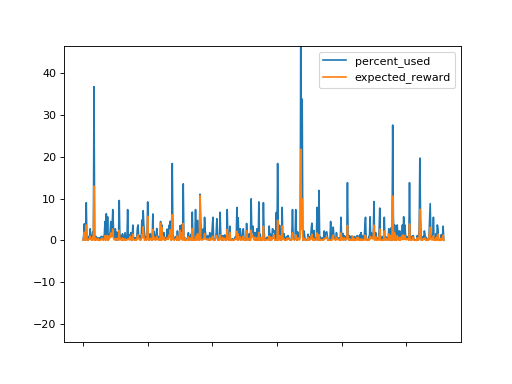

In [38]:
simulation_df.dropna()[['percent_used', 'expected_reward']].plot();

In [17]:
from voter.rshares import get_post_curator_payout

payout_diffs = []
all_payouts = []
for post in post_cache_export.values():
    post_payout, _ = get_post_curator_payout(post)
    post_rshares = sum([int(x['rshares']) for x in post['active_votes']])
    estimate_payout = post_rshares * global_params['RSHARES_TO_SBD'] * 0.25
    payout_diffs.append(post_payout - estimate_payout)
    all_payouts.append(post_payout)

In [18]:
sum(payout_diffs)/sum(all_payouts)

0.04565461093428019

<IPython.core.display.Javascript object>


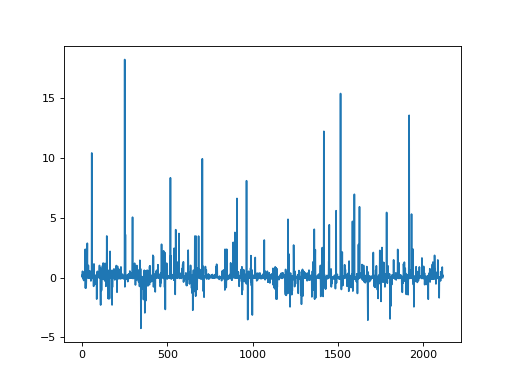

In [16]:
plt.figure()
plt.plot(payout_diffs)